In [235]:
!pip install gym

Defaulting to user installation because normal site-packages is not writeable


In [236]:


import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt 

from os import path
from typing import Optional


import matplotlib.pyplot as plt
import numpy as np


In [237]:
class Environment(object):
    def __init__(self, state, mu, m, g, thetamin = 0, thetamax = np.pi, phimin = 0, phimax = 2*np.pi, Tmin = 0, Tmax = 20, dt = 0.02, dphi = 0.0175, dtheta = 0.0175):
        self.mu = mu
        self.m = m
        self.g = g
        self.thetamin = thetamin
        self.thetamax = thetamax
        self.phimin = phimin
        self.phimax = phimax
        self.Tmin = Tmin
        self.Tmax = Tmax
        self.dt = dt
        self.state = state

    def reset(self):
        self.state = np.array([0, 1, 0, -1, 0, 0])
    
    def infostep(self, current_step, action):
        x, vx, y, vy, z, vz = self.state
        T, phi, theta = action
        
        ax = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        ay = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        az = self.g - (np.cos(phi) * np.cos(theta)) * T / self.m

        vxn = vx + (ax - self.mu * vx) * (self.dt / 2)
        vyn = vy + (ay - self.mu * vy) * (self.dt / 2)
        vzn = vz + (az - self.mu * vz) * (self.dt / 2)

        xn = x + vxn * self.dt
        yn = y + vyn * self.dt
        zn = z + vzn * self.dt

        vxn = vx + (ax - self.mu * vx) * (self.dt / 2)
        vyn = vy + (ay - self.mu * vy) * (self.dt / 2)
        vzn = vz + (az - self.mu * vz) * (self.dt / 2)

        # reward=0.5* -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)+0.3 * np.sqrt((vx+6 * np.sin(1.2 * self.current_step * self.dt))**2 + (vy-6*np.cos(1.2 * self.current_step * self.dt))**2 + vz**2)
        reward = -np.sqrt((xn - 5 * np.cos(1.2 * current_step * self.dt))**2 + (yn - 5 * np.sin(1.2 * current_step * self.dt))**2 + (zn + 20)**2)
        done = zn < -25 or current_step > (self.Tmax / self.dt)
        self.state = np.array([xn, vxn, yn, vyn, zn, vzn])
        state_array = np.array([xn, vxn, yn, vyn, zn, vzn], dtype=np.float32)

        reward_array = np.array([reward], dtype=np.float32)
        done_array = np.array([done], dtype=np.float32)

        # Return the result array
        return state_array, reward, done
    
    def actionspace(self):
        T = np.linspace(self.Tmin, self.Tmax, self.dt)
        phi = np.linspace(self.phimin, self.phimax, self.dphi)
        theta = np.linspace(self.thetamin, self.thetamax, self.dtheta)
        return np.array([[T, phi, theta] for T in T for phi in phi for theta in theta], dtype=np.float32)

In [238]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print(device)

cpu


In [239]:
#intialise OUACTIONNOISE
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)





# intialise an actor neural network along with forward pass
class ActorNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, output_dims):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = output_dims
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        # W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        # b_init = tf.constant_initializer(0.1)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        x= T.sigmoid(self.mu(x))
        y=x.clone()
        y[0]=x[0]*20
        y[1]=y[1]*2*T.pi
        y[2]=y[2]*T.pi
        # print(x.shape)
        # print(x)
        # Combine the outputs for each dimension
        return y

# intialise a critic neural network along with forward pass like above
class CriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims):
        super(CriticNetwork, self).__init__()
        self.input_dims_state = input_dims[0]
        self.input_dims_action = input_dims[1]
        # print(self.input_dims_state, self.input_dims_action)
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims


        self.fc1_state = nn.Linear(self.input_dims_state, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1_state.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1_state.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1_state.bias.data, -f1, f1)
        self.bn1_state = nn.LayerNorm(self.fc1_dims)

        self.fc1_action = nn.Linear(self.input_dims_action, self.fc1_dims)
        f1_2 = 1./np.sqrt(self.fc1_action.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1_action.weight.data, -f1_2, f1_2)
        T.nn.init.uniform_(self.fc1_action.bias.data, -f1_2, f1_2)
        self.bn1_action = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(2*self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.fc2_dims,1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state, action):
        state_input = F.relu(self.bn1_state(self.fc1_state(state)))
        action_input = F.relu(self.bn1_action(self.fc1_action(action)))
        # print(state_input.shape, action_input.shape)
        # Concatenate state and action inputs
        x = T.cat((state_input, action_input), dim=1)
        
        # concatinate state and action into a new tensor
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.action_value(x)
        
        return x
    
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape):
        self.buffer_size = max_size
        self.count = 0
        self.states = np.zeros((self.buffer_size, input_shape[0])) 
        self.actions = np.zeros((self.buffer_size, input_shape[1]))
        self.rewards = np.zeros((self.buffer_size))
        self.new_states = np.zeros((self.buffer_size, input_shape[0]))
        self.terminal = np.zeros(self.buffer_size, dtype=np.float32)

    def add_sample(self, state, action, reward, new_state, done):
        index = self.count % self.buffer_size
        self.states[index] = state
        self.new_states[index] = new_state
        self.actions[index] = action
        self.rewards[index] = reward
        self.terminal[index] = 1 - done
        self.count += 1

    def return_sample(self, batch_size):
        max_choice = min(self.count, self.buffer_size)

        batch = np.random.choice(max_choice, batch_size)

        states = self.states[batch]
        actions = self.actions[batch]
        rewards = self.rewards[batch]
        new_states = self.new_states[batch]
        terminal = self.terminal[batch]

        return states, actions, rewards, new_states, terminal
    
# intialise the agent class
class DDPG_Agent(object):
    def __init__(self, alpha, beta, input_dims_actor,input_dims_critic,input_dims_buff,tau, gamma=0.99, n_actions=3, max_size=1000000, layer1_size=40, layer2_size=30, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims_buff)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.actor = ActorNetwork(alpha,input_dims_actor, layer1_size, layer2_size, output_dims=n_actions)
        self.critic = CriticNetwork(beta,input_dims_critic, layer1_size, layer2_size)
        self.target_actor = ActorNetwork(alpha,input_dims_actor, layer1_size, layer2_size, output_dims=n_actions)
        self.target_critic = CriticNetwork(beta, input_dims_critic, layer1_size, layer2_size)
        
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        
        self.update_network_parameters(tau=1)
        
    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(device)
        mu = self.actor.forward(observation).to(device)
        mu_prime = mu + T.tensor(self.noise(), 
                                 dtype=T.float).to(device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()
    
    def remember(self, state, action, reward, new_state, done):
        self.memory.add_sample(state, action, reward, new_state, done)
    
    def learn(self, num_step):
        if self.memory.count < self.batch_size:
            return
        
        states, actions, rewards, new_states, dones = self.memory.return_sample(self.batch_size)
        
        states = T.tensor(states, dtype=T.float).to(device)
        actions = T.tensor(actions, dtype=T.float).to(device)
        rewards = T.tensor(rewards, dtype=T.float).to(device)
        new_states = T.tensor(new_states, dtype=T.float).to(device)
        dones = T.tensor(dones).to(device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        
        target_actions = self.target_actor.forward(new_states)
        # print(target_actions.shape)
        # print(new_states.shape)
        target_critics = self.target_critic.forward(new_states, target_actions)
        critic_value = self.critic.forward(states, actions)
        

        y = []
        for j in range(self.batch_size):
            y.append(rewards[j] + self.gamma*target_critics[j]*dones[j])
        y = T.tensor(y).to(device)
        y = y.view(self.batch_size, 1)
        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(y, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()


        
        self.actor.optimizer.zero_grad()
        self.critic.eval()
        self.actor.eval()
        actor_loss = T.mean(-self.critic.forward(states, self.actor.forward(states)))
        self.actor.train()
        actor_loss.backward()
        self.actor.optimizer.step()
        if num_step == 0:
            self.update_network_parameters()

        
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + (1-tau)*target_critic_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + (1-tau)*target_actor_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)








In [240]:

agent = DDPG_Agent(alpha=0.0001, beta=0.001, input_dims_actor=[6], input_dims_critic=[6,3], input_dims_buff=[6,3], tau=0.001, batch_size=64, layer1_size=30, layer2_size=30, n_actions=3)
env = Environment(state = np.array([0, 1, 0, -1, 0, 0]), mu = 0.05, m = 1, g = 9.8, thetamin = 0, thetamax = np.pi, phimin = 0, phimax = 2*np.pi, Tmin = 0, Tmax = 20, dt = 0.02, dphi = 0.0175, dtheta = 0.0175)
np.random.seed(0)

score_history = []
for i in range(100):
    state = [0, 1, 0, -1, 0, 0]
    done = False
    score = 0
    its = 0
    while not done and its<300:
        act = agent.choose_action(state)
        # print(act)
        new_state, reward, done = env.infostep(its,act)
        agent.remember(state, act, reward, new_state, int(done))
        agent.learn(its%18)
        score += reward
        state = new_state
        its+=1
        
    score_history.append(score)


    print('episode ', i, 'score', score)





episode  0 score -18750.532743454292
episode  1 score -82217.86797660531
episode  2 score -173917.8600975492
episode  3 score -291214.6508254753
episode  4 score -435595.4976025892
episode  5 score -606440.8598184232
episode  6 score -801598.7664811008
episode  7 score -1017405.706265979
episode  8 score -1264325.868586235
episode  9 score -1576275.7627875875
episode  10 score -1887766.4362128167
episode  11 score -2153811.6376079163
episode  12 score -2423085.0288514504
episode  13 score -2729383.9101787605
episode  14 score -3047088.1541244444
episode  15 score -3352088.967008197
episode  16 score -3649775.584636014
episode  17 score -3963794.0122041423
episode  18 score -4288973.474470978
episode  19 score -4618776.32080304
episode  20 score -4951515.757577785
episode  21 score -5287559.232652672
episode  22 score -5626912.747409056
episode  23 score -5969312.946360716
episode  24 score -6314279.701272011
episode  25 score -6660414.101513062
episode  26 score -7002243.0243188385
epi

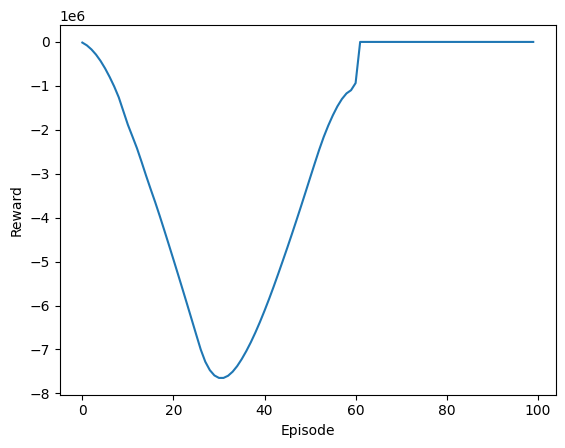

In [241]:
plt.plot(np.arange(len(score_history)), score_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()